# <center> Проект телекоммуникации

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

* `contract_new.csv` — информация о договоре
* `personal_new.csv` — персональные данные клиента
* `internet_new.csv` — информация об интернет-услугах
* `phone_new.csv` — информация об услугах телефонии

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from ydata_profiling import ProfileReport
except:
    !pip install ydata-profiling
    from ydata_profiling import ProfileReport
    
try:
    from skimpy import clean_columns
except:
    !pip install skimpy
    from skimpy import clean_columns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import Pool, CatBoostClassifier
from catboost.utils import get_confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

try:
    import shap
except:
    !pip install shap
    import shap

plt.style.use('seaborn-whitegrid')
RANDOM_STATE = 30723

In [2]:
try:
    contract_new = pd.read_csv('contract_new.csv')
    personal_new = pd.read_csv('personal_new.csv')
    internet_new = pd.read_csv('internet_new.csv')
    phone_new = pd.read_csv('phone_new.csv')
except:
    contract_new = pd.read_csv('/datasets/contract_new.csv')
    personal_new = pd.read_csv('/datasets/personal_new.csv')
    internet_new = pd.read_csv('/datasets/internet_new.csv')
    phone_new = pd.read_csv('/datasets/phone_new.csv')

In [3]:
dict0 = {'Contract': contract_new, 'Personal': personal_new, 'Internet': internet_new, 'Phone': phone_new }
for title, df in dict0.items():
    print(f'\033[1m Отчет по таблице: {title}\033[0m')
    profile = ProfileReport(df)
    profile.to_widgets()

 Отчет по таблице: Contract


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

 Отчет по таблице: Personal


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

 Отчет по таблице: Internet


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

 Отчет по таблице: Phone


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

**План**:
1. Изучить и провести предобработку данных:
    - В данных отсутствуют пропуски, однако можно заметить, что данные по некоторым клиентам отстутсвтуют.
    - Необходимо переименовать названия некоторых признаков, приведя их в единый стиль.
    - Тип данных в признаках BeginDate, EndDate необходимо перевести в формат даты, TotalCharges - в числовой.
    - Можно применить метод OHE для следующих признаков: `type, PaymentMethod, PaperlessBilling, gender, Partner, Dependents, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines`
2. Провести исследовательский анализ данных, обработать выбросы, объединить/создать новые признаки.
3. Объединить данные и разбить их на обучающую и тестовую выборк в соотношении 3:1.
4. Обучить модели, подобрав гиперпараметры, и выбрать наилучшую.
5. Проверить лучшую модель на тестовой выборке.
6. Сделать выводы

**Вопросы**
1. Если EndDate - целевой признак, то можно ли создать новый столбец, где, например, 1 - клиент ушел (EnddATE = дате), 0 - клиент остался (EndDate = No), при этом удалив EndDate?
2. Какую метрику и какую границу использовать для моделей?
3. Можно ли для признаков с 2 значениями: Yes/No использовать порядковое кодирование?

## Предобработка данных

* Приведем названия признаков к единому регистру 

In [4]:
contract = clean_columns(contract_new)
personal = clean_columns(personal_new)
internet = clean_columns(internet_new)
phone = clean_columns(phone_new)

8 column names have been cleaned

4 column names have been cleaned

8 column names have been cleaned

2 column names have been cleaned

* Добавим целевой признак

In [5]:
contract['target'] = np.where(contract['end_date'] == 'No', 0, 1)  

* Добавим новый признак: продлжительность пользования услугами

In [6]:
contract['end_date'] = np.where(contract['end_date'] == 'No', '2020-02-01', contract['end_date'] )

In [7]:
contract[['begin_date','end_date']] = contract[['begin_date','end_date']].apply(pd.to_datetime)
contract['duration_days'] = (contract['end_date'] - contract['begin_date']).dt.days

In [8]:
contract = contract.drop(columns = ['begin_date','end_date'] )

* Обработаем столбец total_charges

In [9]:
contract[contract['total_charges'] == ' ']

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration_days
488,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,Two year,No,Mailed check,73.35,,0,0


In [10]:
contract['total_charges'] = np.where(contract['total_charges'] == ' ', 0, contract['total_charges'] )

In [11]:
contract['total_charges'] = contract['total_charges'].astype(float)

* Объединим таблицы

In [12]:
df = contract.merge(personal,how ='left').merge(internet,how ='left').merge(phone,how ='left')
df.set_index('customer_id', inplace=True)

In [13]:
df.loc[:, df.columns != 'multiple_lines'] = df.loc[:, df.columns != 'multiple_lines'].fillna('No')

In [14]:
df['multiple_lines'] = df['multiple_lines'].fillna('Unknown') 

## Исследовательский анализ данных полного датасета

In [15]:
print(f'\033[1m Отчет\033[0m')
profile_full = ProfileReport(df)
profile_full.to_widgets()

 Отчет


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Обучение моделей 

In [16]:
features = df.drop(columns=['target'])
target = df['target'] 

In [17]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=RANDOM_STATE)

In [18]:
num = ['monthly_charges', 'total_charges', 'duration_days']
cat = ['type', 'paperless_billing', 'payment_method',
       'gender', 'senior_citizen','partner', 'dependents', 
       'internet_service', 'online_security','online_backup', 
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines']

In [19]:
preprocessor_ohe = ColumnTransformer([
    ('nums', StandardScaler(), num),
    ('one_hot', OneHotEncoder(drop='first', handle_unknown='error'), cat)], 
                                remainder='passthrough')

preprocessor_ord = ColumnTransformer([
    ('nums', StandardScaler(), num),
    ('one_hot', OrdinalEncoder(), cat)], 
                                remainder='passthrough')

### Decision Tree

Далее ячейки с подбором гиперпараметров закомментированы, т.к. их выполнение занимает время. Полученные гиперпараметры используются для поиска наилучшей модели.

In [20]:
# model_dt = Pipeline(steps =[
#     ('preprocessor', preprocessor_ohe),
#     ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))])

# parameters = {'model__max_depth': range(1,22),
#               'model__min_samples_leaf': range(1,10)}

# dt_grid = GridSearchCV(model_dt, parameters, cv=5, scoring='roc_auc').fit(features_train, target_train)

# print("Лучшая модель")
# print(dt_grid.best_estimator_)
# print(dt_grid.best_score_)

In [21]:
model_dt = Pipeline(steps =[
    ('preprocessor', preprocessor_ohe),
    ('model', DecisionTreeClassifier(max_depth=6, 
                                     min_samples_leaf=7, 
                                     random_state=RANDOM_STATE))])

score_dt = cross_val_score(model_dt, features_train, target_train, cv=5, scoring='roc_auc').mean()

### Logistic Regression

In [22]:
# model_lr = Pipeline(steps =[
#     ('preprocessor', preprocessor_ohe),
#     ('model', LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs'))])

# parameters = {'model__C': [100, 10, 1.0, 0.1, 0.01]}

# lr_grid = GridSearchCV(model_lr, parameters, cv=5, scoring='roc_auc').fit(features_train, target_train)

# print("Лучшая модель")
# print(lr_grid.best_estimator_)
# print(lr_grid.best_score_)

In [23]:
model_lr = Pipeline(steps =[
    ('preprocessor', preprocessor_ohe),
    ('model', LogisticRegression(C=10, 
                                 random_state=RANDOM_STATE))])

score_lr = cross_val_score(model_lr, features_train, target_train, cv=5, scoring='roc_auc').mean()

### Random Forest

In [24]:
# model_rf = Pipeline(steps =[
#     ('preprocessor', preprocessor_ord),
#     ('model', RandomForestClassifier(random_state=RANDOM_STATE))])

# parameters = {'model__n_estimators': [1,2,4,8,16,32,64,128],
#               'model__max_depth': range(2,22, 2),
#               'model__min_samples_split': [2,4,6,8,10],
#               'model__min_samples_leaf': [2,4,6,8,10]}

# rf_grid = GridSearchCV(model_rf, parameters, cv=5, scoring='roc_auc').fit(features_train, target_train)

# print("Лучшая модель")
# print(rf_grid.best_estimator_)
# print(rf_grid.best_score_)

In [25]:
model_rf = Pipeline(steps =[
    ('preprocessor', preprocessor_ord),
    ('model', RandomForestClassifier(max_depth=8, 
                                     min_samples_leaf=2, 
                                     min_samples_split=6, 
                                     n_estimators=128, 
                                     random_state=RANDOM_STATE))])

score_rf = cross_val_score(model_rf,features_train, target_train, cv=5, scoring='roc_auc').mean()

### CatBoost

In [26]:
# model_cb = CatBoostClassifier(random_state=RANDOM_STATE)

# parameters = {
#     'learning_rate': [0.01, 0.03, 0.003, 0.5],
#     'depth': range(2, 11, 2)}

# cb_grid = GridSearchCV(model_cb, parameters, cv=5, scoring='roc_auc').fit(features_train, target_train, 
#                                                                           cat_features=cat, verbose=10)

# print("Лучшая модель")
# print(cb_grid.best_params_)
# print(cb_grid.best_score_)

In [27]:
model_cb = CatBoostClassifier(depth=2, 
                              learning_rate=0.5,
                              loss_function='Logloss',
                              cat_features=cat,
                              verbose=0, 
                              random_state=RANDOM_STATE)


score_cb = cross_val_score(model_cb,features_train, target_train, cv=5, scoring='roc_auc').mean()

### LightGBM

In [28]:
features_train[cat] = features_train[cat].astype('category')
features_test[cat] = features_test[cat].astype('category')

In [29]:
# model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)

# parameters = {
#     'num_leaves': [7, 14, 21, 28, 31, 50],
#     'learning_rate': [0.1, 0.03, 0.003, 0.005, 0.05, 0.1, 0.5, 0.8],
#     'max_depth': range(2, 30, 2),
#     'n_estimators': [50, 100, 200, 500]}

# lgbm_grid = GridSearchCV(model_lgbm, parameters, cv=5, scoring='roc_auc', n_jobs=-1).fit(features_train, target_train)

# print("Лучшая модель")
# print(lgbm_grid.best_estimator_)
# print(lgbm_grid.best_score_)

In [30]:
model_lgbm = LGBMClassifier(learning_rate=0.5, 
                            max_depth=2, 
                            n_estimators=500, 
                            num_leaves=7, 
                            random_state=RANDOM_STATE)

score_lgbm = cross_val_score(model_lgbm, features_train, target_train, cv=5, scoring='roc_auc').mean()

## Анализ моделей

In [31]:
models = ['Decision Tree', 'Linear Regression', 'Random Forest', 'CatBoost', 'LightGBM']
abbreviations = ['dt', 'lr', 'rf', 'cb', 'lgbm']

result = {}
for i, k in zip(models, abbreviations):
    result[i] = [vars()['score_' + k]]

result_table = pd.DataFrame(result, index =  ['ROC_AUC'])
result_table = np.round(result_table,2).astype(str)
result_table.style.highlight_max(color = 'lightgreen', axis = 1)

,Decision Tree,Linear Regression,Random Forest,CatBoost,LightGBM
ROC_AUC,0.79,0.78,0.83,0.93,0.9


## Тестирование лучшей модели

In [32]:
model_cb.fit(features_train, target_train);

In [33]:
probabilities_test = model_cb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
catboost_test_score = roc_auc_score(target_test, probabilities_one_test)

print(f'ROC_AUC лучшей модели на тестовой выборке: \033[1m{catboost_test_score:.2f}\033[0m')

ROC_AUC лучшей модели на тестовой выборке: 0.93


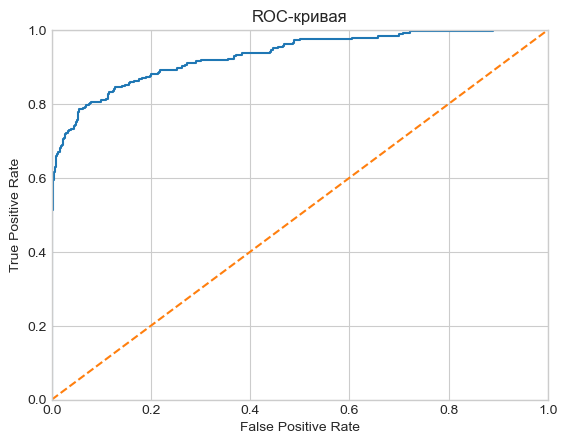

In [34]:
%matplotlib inline
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Проверка модели на адекватность

In [35]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy.fit(features_train, target_train)

probabilities_dummy_test = dummy.predict_proba(features_test)
probabilities_one_dummy_test = probabilities_dummy_test[:, 1]
dummy_test_score = roc_auc_score(target_test, probabilities_one_dummy_test)

print(f'ROC_AUC фиктивной модели: \033[1m{dummy_test_score:.2f}\033[0m')

ROC_AUC фиктивной модели: 0.53


## Анализ признаков 

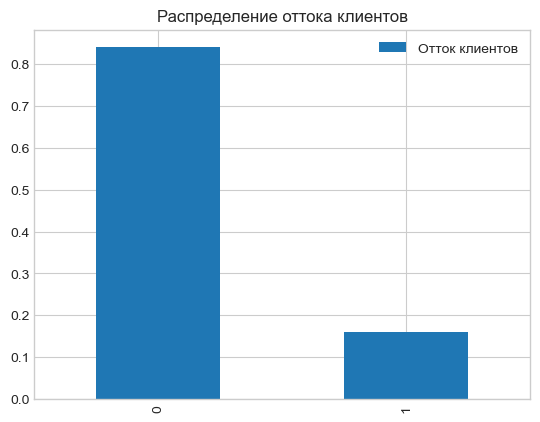

In [36]:
target_test.value_counts(normalize=True).plot(kind='bar', label='Отток клиентов')
plt.legend()
plt.title('Распределение оттока клиентов');

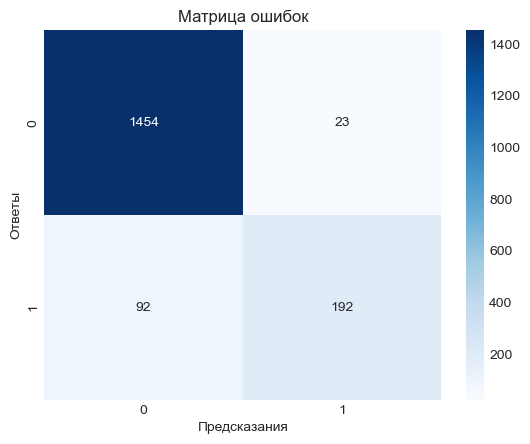

In [37]:
cm = get_confusion_matrix(model_cb, Pool(features_test, target_test, cat_features=cat))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Ответы')
plt.show()

**Вывод**: Проанализировав распределение целевого класса – отток клиентов, определили, что классы 0 и 1 распределены в соотношении 85:15 соответственно. Можно ожидать, что результаты предсказаний моделей будут склоняться к классу 0. Проверили нашу терию, выбранная нами модель в большинстве случаев выдает истинные ответы, модель точно предсказывает остающихся и действительно уходящих клиентов. При этом доля ложноотрицательных и ложноположительных ответов составляет около 5.2% и 1,3% всех ответов соответственно, т.е. модель чаще видит отрицательные ответы (клиент остался), там где их нет. Все это свидетельствует о дисбалансе классов. 

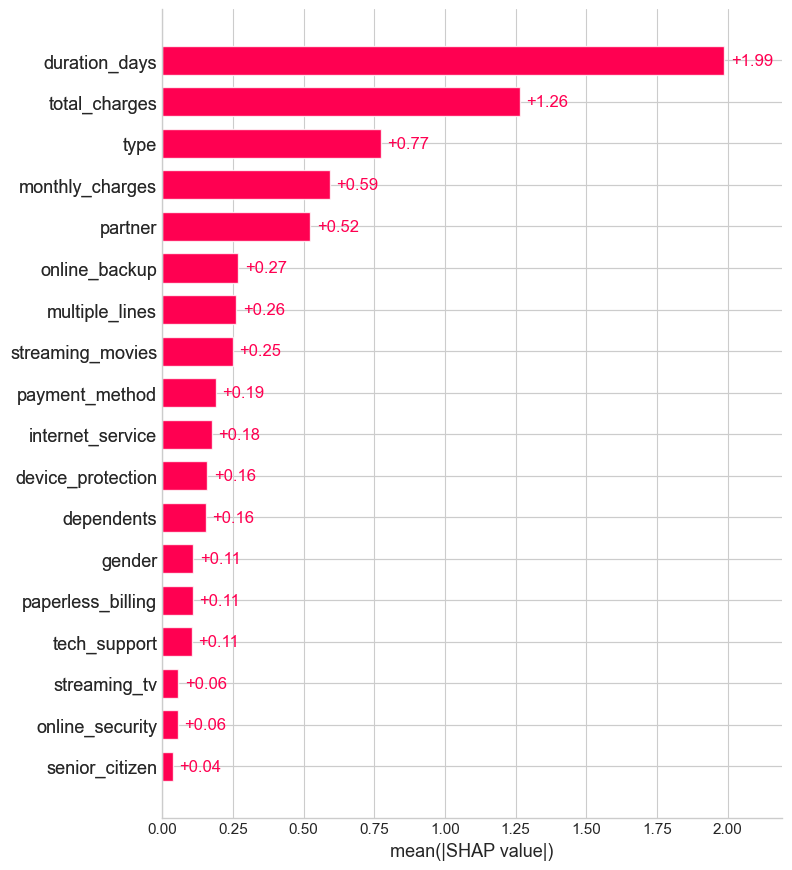

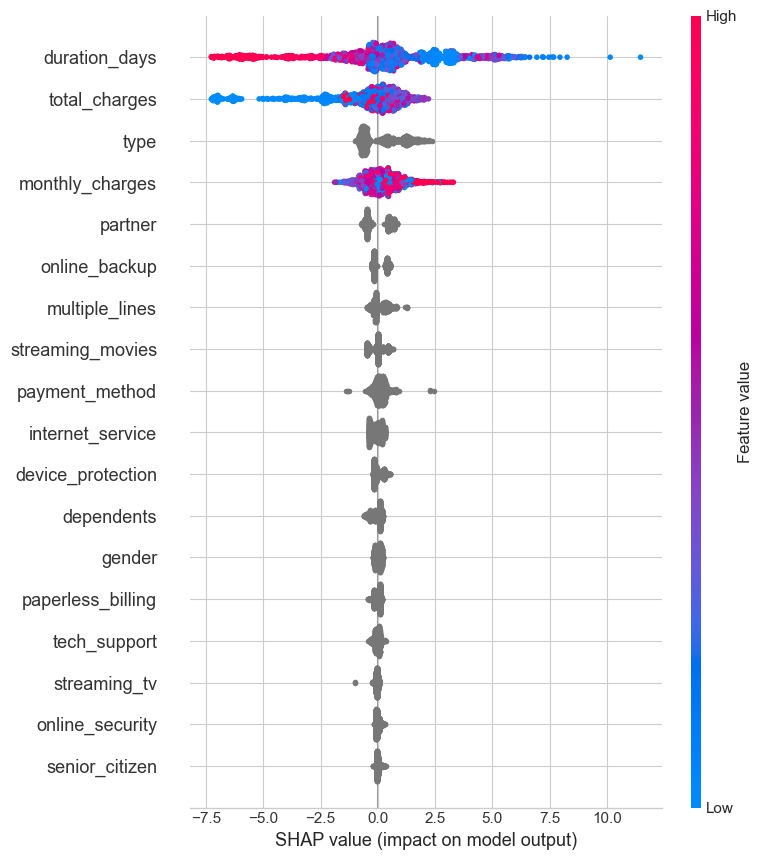

In [38]:
shap.initjs()
explainer = shap.Explainer(model_cb)
shap_values = explainer(features_test)

shap.plots.bar(shap_values, max_display=features_test.shape[0])
shap.summary_plot(shap_values, features_test)

**Вывод**: Очевидное влияние на уход клиента имеет количество дней пользования услугами, количество потраченных денег на услуги как за весь период, так и ежемесячно, а также тип договора. Причем, можно заметить, что чем больше количество дней пользования услугами, тем меньше SHAP-значение, т.е клиент склонен к тому, чтобы продолжить пользоваться услугами. С платой за услуги ситуация седующая: чем меньше клиент отдал за услуги за весь период, тем больше вероятность того, что он останется, а в случае с ежемесячной платой, можно заметить, что увеличение ежемесячной платы способствует оттоку клиента.

### Протестируем модель, оставив только признаки со средним SHAP-значением больше 0.2

In [39]:
unimportant_cols = ['paperless_billing', 'payment_method', 'gender', 
                    'senior_citizen','dependents', 'internet_service', 
                    'online_security','device_protection', 'tech_support', 'streaming_tv']

features_train_upd = features_train.drop(columns=unimportant_cols, axis=1)
features_test_upd = features_test.drop(columns=unimportant_cols, axis=1)

In [40]:
model_cb_upd = CatBoostClassifier(depth=2, 
                              learning_rate=0.5,
                              loss_function='Logloss',
                              cat_features=['type', 'partner','online_backup', 'streaming_movies', 'multiple_lines'],
                              verbose=0, 
                              random_state=RANDOM_STATE)

model_cb_upd.fit(features_train_upd, target_train)

probabilities_test_upd = model_cb_upd.predict_proba(features_test_upd)
probabilities_one_test_upd = probabilities_test_upd[:, 1]

catboost_test_score_upd = roc_auc_score(target_test, probabilities_one_test_upd)

print(f'ROC_AUC модели на тестовой выборке, с меньшим количеством признаков: \033[1m{catboost_test_score_upd:.2f}\033[0m')

ROC_AUC модели на тестовой выборке, с меньшим количеством признаков: 0.93


# Отчет

В ходе работы были выполнены все пункты плана, для полноты исследования была проведена проверка модели на адекватность, исследована значимость признаков в лучшей модели и проведено повторное тестирование модели без учета 'неважных' признаков.
Серьезных трудностей не возникало, единственное требовалась высокая внимательность при изучении данных и их предобработке. 

**В решении задачи выделили следующие ключевые шаги:**

1. **Проведен предварительный анализ и обработка данных**
    - приведен в стандартный стиль названия признаков.
    - добавлен столбец с целевым признаком `target`, на основе признака `end_date`.
    - добавлен признак `duration` (продолжительность пользования услугами в днях) и удалены признаки `begin_date` и `end_date`, чтобы избежать утечки.
    - определено наличие пропусков в признаке `total_charges`. Было выявлено, что наличие пропусков связано с тем, что клиент пользовался услугой менее суток. Соответственно, пропуски были заполнены нулевыми значениями.
    - Были объединены исходные датасеты в единый.
    - Образовавшиеся пропуски в виду отсутствия информации о пользователях были заполнены следующим образом:
        1. в признаках с  информацией об интернет-услугах пропуски заменеы значением `No`,т.к. можно предположить, что если информация отсутсвует, то клиент не пользуется данной услугой.
        2. в признаке `multiple_lines` добавлен новый класс `unknown` вместо пропусков, т.к. нельзя однозначно сказать имеет ли клиент возможность вести паралелльные лини во время звонка или нет.
2. **Проведен исследовательский анализ данных:**
    - Выявлен дисбаланс классов у целевого признака
    - Выявлена высокая корреляция между следующими признаками:
        1. `duration` и `total_charges`: чем дольше клиент пользуется услугами, тем больше его траты.
        2. `monthly_charges` и `internet_service`: наличие интернет-услуг увеличивает ежемесячные траты
        3. Так же присутствует относительно высокая корреляция между ежемесячными тратами и различными типами интернет-услуг.
    - Определено, что большинство клиентов в исследуемой выборке: 
        1. предпочитают заключать помесячный договор;
        2. не пользуются услугами автоматического списания денег, а предпочитают оплачивать через эл. чек.
        3. ежемесячно платят не больше 30 у.е.
        4. не достигли пенсионного возраста и не имеют иждивенцев
        5. неохотно пользуются интернет-услугами  
3. **Подготовленные данные были разбиты на обучабщую и тестовую выборки (3:1)**
4. **Для решения задачи классификации было обучено 5 моделей и былом подобраны гиперпараметры, используя кросс-валидацию:**
    - `Decision Tree`(max_depth=6, min_samples_leaf=7, random_state=RANDOM_STATE)
    - `Logistic Regression`(C=10, random_state=RANDOM_STATE)
    - `Random Forest`(max_depth=8, min_samples_leaf=2, min_samples_split=6, n_estimators=128, random_state=RANDOM_STATE)
    - `CatBoost`(depth=2, learning_rate=0.5, loss_function='Logloss', cat_features=cat, random_state=RANDOM_STATE)
    - `LGBM`(learning_rate=0.5, max_depth=2, n_estimators=500, num_leaves=7, random_state=RANDOM_STATE)

Для категориальных признаков в моделях `Decision Tree, Logistic Regression` предварительно проводилось 'горячее кодирование', в модели `Random Forest` выполнено порядковое кодирование. Все количественные признаки были стандартизированы. Для модели `LGBM` тип категориальных признаков был изменен на `category`.

5. **Наилучшей оказалась модель `CatBoost`:**
    - ROC-AUC на тренировочной выборке: `0.93`
    - ROC-AUC на тестовой выборке: `0.93`

Дополнительно была проведена проверка модели на адекватность, ипользуя `Dummy Classifier`, полученная метрика 0.53.

6. **Проведен анализ самой модели и важности признаков используя SHAP-значение**
    - Выводы представлены непосредственно в коде  
    
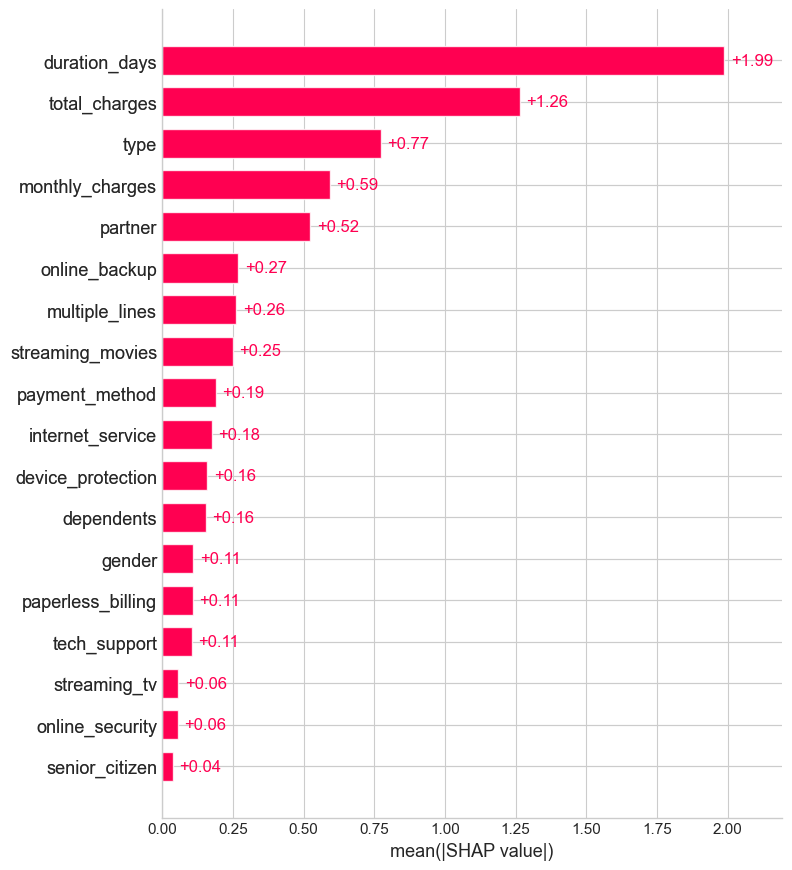
        
7. **Модель была повторно протестирована на выборке с наиболе важными признаками**
    - Удаление 8 'незначимых' признаков не привело к ухудшению метрики, она осталась прежней. Соответственно, можно не использовать данные признаки, сохранив качество и ускорив обучение модели.  
    
        